In [1]:
import os
import sys
p = '..'
while not os.path.isdir(p + '/notebooks'):
    p += '/..'
sys.path.append(p) # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib
import joblib

import src
from src.ml_utils import (
    fetch_ohlcv, 
    visualize_result, 
    normalize_position, 
    calc_position_cv2,
    get_feature_columns,
    get_symbols,
    unbiased_rank,
    ewm_finite,
)
from src.data_fetcher import DataFetcher
cloudpickle.register_pickle_by_value(src) # for model portability

os.environ["USE_JOBLIB_MEMORY"] = "1"

def get_joblib_memory():
    if os.getenv('USE_JOBLIB_MEMORY'):
        return joblib.Memory('/tmp/alphapool_joblib_memory', verbose=0)
    else:
        return joblib.Memory(None, verbose=0)

model_name = '20220919_rank'

In [2]:
# symbols = os.getenv('ALPHAPOOL_SYMBOLS').split(',') # 売買代金が多く、古いもの
# symbols += 'DOGE,SFP,DYDX,AXS,CHZ,TRX,MASK,ETC,LTC,1000SHIB,C98,SAND,SUSHI,NEAR,FIL'.split(',')
# symbols += 'SFP,DYDX,AXS,TRX,MASK,ETC,LTC,1000SHIB,C98,SAND,SUSHI,NEAR,FIL'.split(',')
symbols = ['ADA', 'ATOM', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP', 'ETC', 'LTC'] # binance, bybit, okex
# symbols = ['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP', 'ETC', 'LTC'] # binance, bybit
# symbols = ['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP'] # binance, bybit

provider_configs = [
    {
        'provider': 'bigquery',
        'options': {
            'table': 'binance_ohlcv',
            'symbols': ['{}USDT'.format(x) for x in symbols],
        }
    },
]

dfs = DataFetcher(memory=get_joblib_memory()).fetch(
    provider_configs=provider_configs, 
    min_timestamp=None,
)

for df in dfs:
    display(df)

def merge_data(dfs):
    df = dfs[0]
    df['symbol'] = df['symbol'].str.replace('USDT', '')
    df = df.set_index(['timestamp', 'symbol']).sort_index()
    return df

df = merge_data(dfs)

def merge_kraken_data(df):
    symbols = list(df.index.get_level_values('symbol').unique())
    
    train_provider_configs = [
        {
            'provider': 'bigquery',
            'options': {
                'table': 'kraken_historical_ohlcvt',
                'symbols': symbols,
            }
        },
    ]

    dfs = DataFetcher(memory=get_joblib_memory()).fetch(
        provider_configs=train_provider_configs, 
        min_timestamp=None,
    )
    df_kraken = dfs[0].set_index(['timestamp', 'symbol'])

    df = df.copy()
    df['extended'] = False
    df = pd.concat([df, df_kraken])
    df['extended'] = df['extended'].fillna(True)
    df = df[['op', 'hi', 'lo', 'cl', 'volume', 'twap_5m', 'extended']]
    df = df.loc[~df.index.duplicated()]
    df = df.sort_index()
    return df.copy()

df = merge_kraken_data(df)

df = df.dropna()
df.to_pickle('/tmp/df_binance_ohlcv_extended.pkl')
display(df)

,timestamp,symbol,op,hi,lo,cl,volume,amount,trades,buy_volume,...,twap,twap_5m,cl_std,cl_diff_std,hi_twap,lo_twap,hi_op_max,lo_op_min,ln_hi_lo_mean,ln_hi_lo_sqr_mean
0,2019-10-24 16:00:00+00:00,BTCUSDT,7433.2700,7458.0000,7425.0000,7452.7900,2.883884e+03,2.146007e+07,5001.0,1610.465,...,7441.583167,7441.898333,7.469183,3.917731,7444.100333,7438.831167,2.860167,-2.409000,0.000708,6.210302e-07
1,2019-10-23 03:00:00+00:00,BTCUSDT,8034.6000,8034.6100,7937.0000,7953.2000,4.823014e+03,3.845151e+07,8410.0,2247.640,...,7993.990333,7987.906667,32.453367,8.473770,7998.520000,7990.257833,3.147667,-5.114500,0.001035,2.418837e-06
2,2019-10-21 08:00:00+00:00,BTCUSDT,8220.0300,8223.3100,8200.0000,8220.0800,1.884292e+03,1.547155e+07,3148.0,787.277,...,8211.840167,8212.097500,5.155098,2.106208,8213.307667,8210.237333,1.484833,-1.585500,0.000374,1.796818e-07
3,2019-10-22 05:00:00+00:00,BTCUSDT,8213.0000,8216.8600,8200.0000,8209.0500,2.027282e+03,1.663915e+07,2812.0,1085.684,...,8207.827167,8207.930000,2.494095,1.795042,8209.315667,8206.368833,1.596167,-1.350667,0.000359,1.617892e-07
4,2019-10-24 09:00:00+00:00,BTCUSDT,7442.0400,7468.0000,7430.0000,7433.8100,2.686744e+03,2.000874e+07,4527.0,1199.481,...,7446.607500,7444.494167,7.547849,4.973154,7449.926000,7443.901500,2.860667,-3.163833,0.000809,8.151147e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241637,2022-01-06 01:00:00+00:00,MATICUSDT,2.2040,2.2090,2.1450,2.1658,1.388196e+07,3.026007e+07,48277.0,6040660.000,...,2.183553,2.182717,0.012705,0.004017,2.186607,2.180752,0.002413,-0.003441,0.002683,8.435437e-06
241638,2022-01-02 22:00:00+00:00,MATICUSDT,2.5123,2.5345,2.5113,2.5303,4.489515e+06,1.133739e+07,23375.0,2343854.000,...,2.526055,2.526575,0.004697,0.001549,2.526978,2.524592,0.001218,-0.001168,0.000945,1.137871e-06
241639,2022-01-06 22:00:00+00:00,MATICUSDT,2.2289,2.2671,2.2195,2.2666,6.409873e+06,1.435081e+07,28441.0,3350752.000,...,2.240022,2.240467,0.010433,0.003247,2.241735,2.237627,0.002330,-0.001778,0.001836,4.298820e-06
241640,2022-01-08 03:00:00+00:00,MATICUSDT,2.0915,2.0991,2.0716,2.0905,6.062434e+06,1.264769e+07,25121.0,2769257.000,...,2.087220,2.087917,0.005760,0.002397,2.089287,2.085470,0.002032,-0.001785,0.001829,3.712659e-06


op         hi        lo        cl  \
timestamp                 symbol                                             
2013-10-06 21:00:00+00:00 BTC     122.00000  122.00000  122.0000  122.0000   
2013-10-07 20:00:00+00:00 BTC     123.61000  123.61000  123.6100  123.6100   
2013-10-08 02:00:00+00:00 BTC     123.91000  123.91000  123.9000  123.9000   
2013-10-08 05:00:00+00:00 BTC     124.19000  124.19000  124.1800  124.1800   
2013-10-09 09:00:00+00:00 BTC     124.01687  124.01687  123.8400  123.8400   
...                                     ...        ...       ...       ...   
2022-11-22 04:00:00+00:00 LTC      62.53000   62.72000   62.1900   62.3300   
                          MATIC     0.80460    0.80930    0.7969    0.7993   
                          XRP       0.35870    0.36010    0.3578    0.3580   
2022-11-22 05:00:00+00:00 ETC      18.11700   18.11800   18.0030   18.0320   
                          LTC      62.34000   62.36000   61.7600   61.9300   

                                        volume    twap_5m  extended  
timestamp                 symbol                                     
2013-10-06 21:00:00+00:00 BTC     1.000000e-01  122.00000      True  
2013-10-07 20:00:00+00:00 BTC     1.000000e-01  123.61000      True  
2013-10-08 02:00:00+00:00 BTC     1.991600e+00  123.90000      True  
2013-10-08 05:00:00+00:00 BTC     2.000000e+00  124.18000      True  
2013-10-09 09:00:00+00:00 BTC     2.823000e+00  123.84000      True  
...                                        ...        ...       ...  
2022-11-22 04:00:00+00:00 LTC     2.480588e+05   62.41500     False  
                          MATIC   1.730488e+07    0.80435     False  
                          XRP     3.522573e+07    0.35920     False  
2022-11-22 05:00:00+00:00 ETC     2.523922e+05   18.05375     False  
                          LTC     2.514921e+05   62.05250     False  

[420977 rows x 7 columns]

In [3]:
# based on 20220910_eda

import numba
from pandas.api.types import is_float_dtype

def signed_rsi_sma(x, timeperiod=14):
    v = x.diff(1).fillna(0)
    return (v.rolling(timeperiod, 1).sum() / (1e-37 + v.abs().rolling(timeperiod, 1).sum())).clip(-1, 1)

def uniform_rank(x):
    return unbiased_rank(x)
    # count = x.transform("count")
    # rank = x.rank()
    # return (rank - 0.5) / count

def calc_features(df, with_ret=False):
    mem = get_joblib_memory()
    return mem.cache(do_calc_features)(df, with_ret=with_ret)
    
def do_calc_features(df, with_ret=False):
    dfs = []
    for symbol, df_symbol in df.groupby('symbol'):
        dfs.append(calc_features_single(df_symbol))
    df = pd.concat(dfs).sort_index()

    beta_window = 24 * 30
    # beta_window = 24 * 7
    
    df['beta_weight'] = 1
    # df['beta_weight'] = 1 + df.groupby('symbol')['volume'].transform(lambda x: x.rolling(24 * 7, 1).mean())
    
    def beta_mean(col):
        return (df[col] * df['beta_weight']).groupby('timestamp').transform('mean') / df.groupby('timestamp')['beta_weight'].transform('mean')

    # df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
    df['ln_cl_diff_mean'] = beta_mean('ln_cl_diff')
    
    # wrong
    # df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(beta_window, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0).clip(0.1, 2.0)

    df['beta'] = (
        (df['ln_cl_diff'] * df['ln_cl_diff_mean']).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
        / (df['ln_cl_diff_mean'] ** 2).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
    ).fillna(0).clip(0.1, 2.0)
    # df['beta'] = 1.0
    
    dfs = [
        df,
        # df.drop(columns=get_feature_columns(df)),
    ]
    
    if with_ret:
        ret_mean = df.groupby('timestamp')['ret'].transform('mean')
        ret_mean = beta_mean('ret')
        dfs += [
            (uniform_rank(df.groupby('timestamp')['ret']) - 0.5).rename('ret_rank'),
            (df['ret'] - df['beta'] * ret_mean).rename('ret_beta'),
        ]
    
    for col in get_feature_columns(df):
        feature_mean = beta_mean(col)
        dfs += [
            (2 * uniform_rank(df.groupby('timestamp')[col]) - 1).rename(col + '_symbolrank'),
            (df[col] - df['beta'] * feature_mean).rename(col + '_symbolbeta'),
        ]
    df = pd.concat(dfs, axis=1)
    
    # dfs = [df]
    # for col in get_feature_columns(df):
    #     if '_symbolbeta' not in col:
    #         continue
    #     dfs += [
    #         (2 * uniform_rank(df.groupby('timestamp')[col]) - 1).rename(col.replace('symbolbeta', 'symbolbtrk')),
    #     ]
    # df = pd.concat(dfs, axis=1)
    
    df = df[sorted([x for x in df.columns if is_float_dtype(df.dtypes[x])])].copy().astype('float32')

    return df

def calc_features_single(df):
    df = df.copy()

    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    df['ln_cl'] = np.log(df['cl'])
    df['ln_hi'] = np.log(df['hi'])
    df['ln_lo'] = np.log(df['lo'])
    df['ln_hilo'] = 0.5 * (df['ln_hi'] + df['ln_lo'])
    df['ln_cl_diff'] = df['ln_cl'].diff(1).fillna(0)
    
    def adx(t):
        return (talib.ADX(high, low, close, timeperiod=t) / 100).fillna(0)

    def adxr(t):
        return (talib.ADXR(high, low, close, timeperiod=t) / 100).fillna(0)

    def rsi(t):
        return signed_rsi_sma(close, timeperiod=t).fillna(0)

    def rsi_hilo(t):
        return signed_rsi_sma(0.5 * (high + low), timeperiod=t).fillna(0)

    def rsi_volume(t):
        return signed_rsi_sma(volume, timeperiod=t).fillna(0)

    def aroon_down(t):
        return (talib.AROON(high, low, timeperiod=t)[0] / 100).fillna(0)
    def aroon_up(t):
        return (talib.AROON(high, low, timeperiod=t)[1] / 100).fillna(0)

    def aroonosc(t):
        return (talib.AROONOSC(high, low, timeperiod=t) / 100).fillna(0)

    def cci(t):
        return talib.CCI(high, low, close, timeperiod=t).fillna(0)

    def cmo(t):
        return talib.CMO(close, timeperiod=t).fillna(0)

    def dx(t):
        return (talib.DX(high, low, close, timeperiod=t) / 100).fillna(0)

    def mfi(t):
        return (talib.MFI(high, low, close, volume, timeperiod=t) / 50 - 1).fillna(0)

    def trix(t):
        return talib.TRIX(close, timeperiod=t).fillna(0)

    def atr(t):
        return talib.ATR(high, low, close, timeperiod=t).fillna(0)

    def natr(t):
        return talib.NATR(high, low, close, timeperiod=t).fillna(0)

    def ma_kairi(t):
        return df['ln_cl'] - df['ln_cl'].rolling(t, 1).mean()

    def mid_kairi(t):
        return df['ln_cl'] - 0.5 * (df['ln_hi'].rolling(t, 1).max() + df['ln_lo'].rolling(t, 1).min())

    def median_kairi(t):
        return df['ln_cl'] - df['ln_cl'].rolling(t, 1).median()

    def zscore(t):
        return ((df['ln_cl'] - df['ln_cl'].rolling(t, 1).mean()) / df['ln_cl'].rolling(t, 1).std()).fillna(0)

    def volume_corr(t):
        return df['volume'].rolling(t, 1).corr(df['cl']).fillna(0).clip(-1, 1)

    def range_pos_general(x, t):
        hi = x.rolling(t, 1).max()
        lo = x.rolling(t, 1).min()
        return (2 * (x - lo) / (hi - lo) - 1).fillna(0)

    def range_pos(t):
        hi = df['ln_hi'].rolling(t, 1).max()
        lo = df['ln_lo'].rolling(t, 1).min()
        return (2 * (df['ln_cl'] - lo) / (hi - lo) - 1).fillna(0)

    def range_pos_rank(t):
        return skew_ratio(df['ln_cl'], df['ln_cl'], np.ones(df.shape[0]), t)

    def obv_rsi(t):
        return signed_rsi_sma(talib.OBV(close, volume), timeperiod=t).fillna(0)

    def ad_rsi(t):
        return signed_rsi_sma(talib.AD(high, low, close, volume), timeperiod=t).fillna(0)
    
    def bwmfi_rsi(t):
        bwmfi = (df['hi'] - df['lo']) / (1 + df['volume'])
        return signed_rsi_sma(bwmfi, timeperiod=t).fillna(0)

    def macdsignal(t):
        return talib.MACDEXT(df['ln_cl'], fastperiod=int(max(2, t / 26.0 * 12)), slowperiod=max(2, t), signalperiod=int(max(2, t / 26.0 * 9)))[1].fillna(0)

    def stoch(t):
        k, d = talib.STOCH(high, low, close, fastk_period=t, slowk_period=int(max(2, t / 5.0 * 3)), slowd_period=int(max(2, t / 5.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def stochf(t):
        k, d = talib.STOCHF(high, low, close, fastk_period=t, fastd_period=int(max(2, t / 5.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def stochrsi(t):
        k, d = talib.STOCHRSI(close, timeperiod=t, fastk_period=int(max(2, t / 14.0 * 5)), fastd_period=int(max(2, t / 14.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def ultosc(t):
        return (talib.ULTOSC(high, low, close, timeperiod1=max(2, t // 4), timeperiod2=max(2, t // 2), timeperiod3=t) / 50 - 1).fillna(0)

    def volume_ratio(t):
        return ((np.sign(close.diff(1).fillna(0)) * volume).rolling(t, 1).sum() / volume.rolling(t, 1).sum()).fillna(0).clip(-1, 1)

    @numba.njit
    def do_skew_ratio(ref_price, price, weight, t):
        n = ref_price.shape[0]
        y = ref_price.copy()
        for i in range(n):
            price_slice = price[max(0, i - t + 1):i + 1]
            weight_slice = weight[max(0, i - t + 1):i + 1]
            y[i] = np.sum(np.sign(price_slice - ref_price[i]) * weight_slice) / (1e-37 + np.sum(weight_slice))
        return y
    
    def skew_ratio(ref_price, price, weight, t):
        return pd.Series(do_skew_ratio(ref_price.values, price.values, to_numpy(weight), t), index=ref_price.index).fillna(0)
    
    def to_numpy(x):
        if hasattr(x, 'values'):
            return x.values
        else:
            return x

    dfs = [
        df,
    ]

    # for t in [24]:
    for t in [6, 12, 24, 36, 48, 72, 96]:
    # for t in [2, 4, 8, 16]:
    # for t in [2, 4, 8, 16, 32, 64]:
        feature_mom = df['ln_cl_diff'].rolling(t, 1).mean().fillna(0).rename('feature_mom_{}'.format(t))
        feature_integ_std = df['ln_cl'].rolling(t, 1).std().fillna(0).rename('feature_integ_std_{}'.format(t))
        feature_std = df['ln_cl_diff'].rolling(t, 1).std().fillna(0).rename('feature_std_{}'.format(t))

        feature_stoch_k, feature_stoch_d = stoch(t)
        feature_stoch_k = feature_stoch_k.rename('feature_stoch_k_{}'.format(t))
        feature_stoch_d = feature_stoch_d.rename('feature_stoch_d_{}'.format(t))

        feature_stochf_k, feature_stochf_d = stochf(t)
        feature_stochf_k = feature_stochf_k.rename('feature_stochf_k_{}'.format(t))
        feature_stochf_d = feature_stochf_d.rename('feature_stochf_d_{}'.format(t))

        feature_stochrsi_k, feature_stochrsi_d = stochrsi(t)
        feature_stochrsi_k = feature_stochrsi_k.rename('feature_stochrsi_k_{}'.format(t))
        feature_stochrsi_d = feature_stochrsi_d.rename('feature_stochrsi_d_{}'.format(t))

        feature_rsi = rsi(t).rename('feature_rsi_{}'.format(t))
        
        ln_hilo_vwap = ((df['ln_hilo'] * df['volume']).rolling(t, 1).sum() / df['volume'].rolling(t, 1).sum()).fillna(0)
        

        dfs += [
            adx(t).rename('feature_adx_{}'.format(t)),
            adxr(t).rename('feature_adxr_{}'.format(t)),
            feature_rsi,
            rsi_hilo(t).rename('feature_rsi_hilo_{}'.format(t)),
            rsi_volume(t).rename('feature_rsi_volume_{}'.format(t)),
            aroon_down(t).rename('feature_aroon_down_{}'.format(t)),
            aroon_up(t).rename('feature_aroon_up_{}'.format(t)),
            aroonosc(t).rename('feature_aroonosc_{}'.format(t)),
            # cci(t).rename('feature_cci_{}'.format(t)),
            # cmo(t).rename('feature_cmo_{}'.format(t)),
            dx(t).rename('feature_dx_{}'.format(t)),
            mfi(t).rename('feature_mfi_{}'.format(t)),
            # trix(t).rename('feature_trix_{}'.format(t)),
            # feature_integ_std,
            # feature_std,
            # (feature_std - feature_integ_std).fillna(0).rename('feature_mean_reversion_sub_{}'.format(t)),
            # feature_mom,
            # atr(t).rename('feature_atr_{}'.format(t)),
            # natr(t).rename('feature_natr_{}'.format(t)),
            range_pos_general(natr(t), t).rename('feature_natr_range_pos_{}'.format(t)),
            # ma_kairi(t).rename('feature_ma_kairi_{}'.format(t)),
            # mid_kairi(t).rename('feature_mid_kairi_{}'.format(t)),
            # median_kairi(t).rename('feature_median_kairi_{}'.format(t)),
            # df['ln_cl_diff'].rolling(t, 1).kurt().fillna(0).rename('feature_kurt_{}'.format(t)),
            # df['ln_cl_diff'].rolling(t, 1).skew().fillna(0).rename('feature_skew_{}'.format(t)),
            # df['ln_cl'].rolling(t, 1).kurt().fillna(0).rename('feature_integ_kurt_{}'.format(t)),
            # df['ln_cl'].rolling(t, 1).skew().fillna(0).rename('feature_integ_skew_{}'.format(t)),
            volume_corr(t).rename('feature_volume_corr_{}'.format(t)),
            range_pos(t).rename('feature_range_pos_{}'.format(t)),
            range_pos_rank(t).rename('feature_range_pos_rank_{}'.format(t)),
            # skew_ratio(df['ln_cl'], df['ln_hilo'], df['volume'], t).rename('feature_volume_range_pos_rank_{}'.format(t)), # ???
            obv_rsi(t).rename('feature_obv_rsi_{}'.format(t)),
            ad_rsi(t).rename('feature_ad_rsi_{}'.format(t)),
            # bwmfi_rsi(t).rename('feature_bwmfi_rsi_{}'.format(t)), # seems to be useless
            # macdsignal(t).rename('feature_macdsignal_{}'.format(t)),
            feature_stoch_k,
            feature_stoch_d,
            (0.5 * (feature_stoch_k + feature_stoch_d)).rename('feature_stoch_mean_{}'.format(t)),
            (0.5 * (feature_stoch_k - feature_stoch_d)).rename('feature_stoch_sub_{}'.format(t)),
            feature_stochf_k,
            feature_stochf_d,
            (0.5 * (feature_stochf_k + feature_stochf_d)).rename('feature_stochf_mean_{}'.format(t)),
            (0.5 * (feature_stochf_k - feature_stochf_d)).rename('feature_stochf_sub_{}'.format(t)),
            feature_stochrsi_k,
            feature_stochrsi_d,
            (0.5 * (feature_stochrsi_k + feature_stochrsi_d)).rename('feature_stochrsi_mean_{}'.format(t)),
            (0.5 * (feature_stochrsi_k - feature_stochrsi_d)).rename('feature_stochrsi_sub_{}'.format(t)),
            ultosc(t).rename('feature_ultosc_{}'.format(t)),
            volume_ratio(t).rename('feature_volume_ratio_{}'.format(t)),
            skew_ratio(df['ln_cl'].rolling(t, 1).mean(), df['ln_cl'], np.ones(df.shape[0]), t).rename('feature_skew_ratio_{}'.format(t)),
            # skew_ratio(ln_hilo_vwap, df['ln_hilo'], df['volume'], t).rename('feature_volume_skew_ratio_{}'.format(t)), # ???
            (feature_std / (feature_std + feature_integ_std)).fillna(0).rename('feature_mean_reversion_ratio_{}'.format(t)),
            feature_rsi.rolling(t, 1).std().fillna(0).rename('feature_rsi_integ_std_{}'.format(t)),
            (feature_rsi.diff(1).fillna(0).rolling(t, 1).std() / 2).fillna(0).rename('feature_rsi_std_{}'.format(t)),
            # dimension less but not bounded
            # (feature_std / feature_integ_std).fillna(0).rename('feature_mean_reversion_{}'.format(t)),
            # (feature_mom / feature_std).fillna(0).rename('feature_sharpe_{}'.format(t)),
            # zscore(t).rename('feature_zscore_{}'.format(t)),
            # feature_rsi.diff(1).fillna(0).rolling(t, 1).kurt().fillna(0).rename('feature_rsi_kurt_{}'.format(t)),
            # feature_rsi.diff(1).fillna(0).rolling(t, 1).skew().fillna(0).rename('feature_rsi_skew_{}'.format(t)),
            # feature_rsi.rolling(t, 1).kurt().fillna(0).rename('feature_rsi_integ_kurt_{}'.format(t)),
            # feature_rsi.rolling(t, 1).skew().fillna(0).rename('feature_rsi_integ_skew_{}'.format(t)),
        ]

    return pd.concat(dfs, axis=1)

In [4]:

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor, VotingRegressor

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cluster import FeatureAgglomeration
import xgboost as xgb
from sklearn.ensemble import HistGradientBoostingRegressor, BaggingRegressor
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer

class ExampleModelRank:
    def __init__(self):
        # self._model = Ridge(fit_intercept=False, alpha=1e20)
        # self._model = Pipeline([
        #     ('ss', StandardScaler()),
        #     ('model', self._model)
        # ])
        
        self._model = lgb.LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.01,
            extra_trees=True,
            colsample_bytree=0.9,
            # lambda_l2=1e1,
            random_state=1,
            n_jobs=-1,
        )
        
        # self._model = lgb.LGBMClassifier(
        #     # n_estimators=1000,
        #     # learning_rate=0.001,
        #     random_state=1,
        #     n_jobs=-1,
        # )
        self._model = BaggingRegressor(self._model, random_state=1)
        
        # union = FeatureUnion([
        #     ("pt", 'passthrough'),
        #     ("pca", PCA(n_components=32)),
        #     ("svd", TruncatedSVD(n_components=32)),
        #     ("agg", FeatureAgglomeration(n_clusters=32)),
        # ])
        # self._model = Pipeline([
        #     # ('feat_agglo', FeatureAgglomeration(n_clusters=64)),
        #     ('union', union),
        #     ('model', self._model)
        # ])
        
        
        self.max_data_sec = 2 * 30 * 24 * 60 * 60 # for predict script
        self.provider_configs = provider_configs
        self.merge_data = merge_data

    def fit(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        
        df['ret_train'] = df['ret']
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-24) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-4) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df['ln_hilo']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilocl'].shift(-24) - df['ln_hilocl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df.groupby('symbol')['ln_hilo'].shift(12)).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-48) - df['ln_hilo']).fillna(0)
        # def calc_ret(x):
        #     hi = df.loc[x.index, 'hi']
        #     lo = df.loc[x.index, 'lo']
        #     return 0.5 * (hi.rolling(24, 1).max().shift(-24) + lo.rolling(24, 1).min().shift(-24)) / x - 1
        # df['ret_train'] = df.groupby('symbol')['cl'].transform(calc_ret)
        
        df['ret_rank'] = unbiased_rank(df.groupby('timestamp')['ret_train']) - 0.5
        # df['ret_mean'] = df.groupby('timestamp')['ret_train'].transform('mean')
        # df['ret_beta'] = df['ret_train'] - df['ret_mean'] * df['beta']
        df = df.dropna()
        self.symbols = get_symbols(df) # for predict script
        
        print('fit df.shape', df.shape)
        
        # dfs = []
        # for i in range(4):
        #     df2 = df.copy()
        #     df2[features] = df2[features] + np.random.normal(0, 0.1, (df.shape[0], len(features)))
        #     dfs += [
        #         df2
        #     ]
        # df = pd.concat(dfs)
        
        # df[features] += np.random.normal(0, 0.1, (df.shape[0], len(features)))
        
        # return self._model.fit(df[features], df['ret_beta'])
        # return self._model.fit(df[features], np.sign(df['ret_beta']), sample_weight=np.abs(df['ret_beta']))
        return self._model.fit(df[features], df['ret_rank'])
        # return self._model.fit(df[features], np.sign(df['ret_rank']), sample_weight=np.abs(df['ret_rank']))
        # return self._model.fit(df[features], np.sign(df['ret_rank']), model__sample_weight=np.abs(df['ret_rank']))
    
    def predict(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        y_pred = self._model.predict(df[features])
        # df['position'] = np.sign(y_pred)
        df['position'] = y_pred
        # df['position'] = unbiased_rank(df.groupby('timestamp')['position']) - 0.5
        df['position_beta'] = df['position'] * df['beta']
        df['position'] -= df.groupby('timestamp')['position_beta'].transform('mean')
        
        # df['position'] = df.groupby('symbol')['position'].transform(lambda x: calc_pos(x, 0.4))
        
        normalize_position(df)
        return df['position']
    
    def _calc_features(self, df):        
        df = df.copy()
        df = calc_features(df)
        
        # dfs = [df]
        # for col in get_feature_columns(df):
        #     dfs += [
        #         (df[col] ** 2).rename(col + '_sqr'),
        #     ]
        # df = pd.concat(dfs, axis=1)
        
        return df

/tmp/ipykernel_12/2601597073.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta_weight'] = 1
/tmp/ipykernel_12/2601597073.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = beta_mean('ln_cl_diff')
/tmp/ipykernel_12/2601597073.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = f

fit df.shape (397361, 730)


/tmp/ipykernel_12/2601597073.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta_weight'] = 1
/tmp/ipykernel_12/2601597073.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = beta_mean('ln_cl_diff')
/tmp/ipykernel_12/2601597073.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = f

fit df.shape (364019, 730)


/tmp/ipykernel_12/2601597073.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta_weight'] = 1
/tmp/ipykernel_12/2601597073.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = beta_mean('ln_cl_diff')
/tmp/ipykernel_12/2601597073.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = f

fit df.shape (339684, 730)


/tmp/ipykernel_12/2601597073.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta_weight'] = 1
/tmp/ipykernel_12/2601597073.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = beta_mean('ln_cl_diff')
/tmp/ipykernel_12/2601597073.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = f

fit df.shape (300206, 730)


/tmp/ipykernel_12/2601597073.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta_weight'] = 1
/tmp/ipykernel_12/2601597073.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = beta_mean('ln_cl_diff')
/tmp/ipykernel_12/2601597073.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = f

fit df.shape (281215, 730)


/tmp/ipykernel_12/2601597073.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta_weight'] = 1
/tmp/ipykernel_12/2601597073.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = beta_mean('ln_cl_diff')
/tmp/ipykernel_12/2601597073.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = f

return without cost statistics
mean 0.002584267628865253
std 0.0383698623685348
sharpe 0.06735149592260413
double sharpe 0.7937494488449808
max drawdown 45.734233089499526
min -1.1184190106491763
min sharpe 0.0023106435104006664
return with cost statistics
mean 0.001774801206044818
std 0.038367984898498804
sharpe 0.04625734738845405
double sharpe 0.5270459766614458
max drawdown 47.980191617226296
min -1.1194190106491764
min sharpe 0.001585466379578073


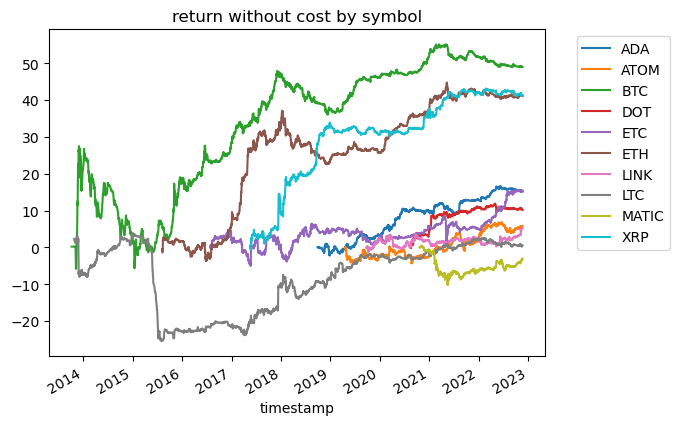

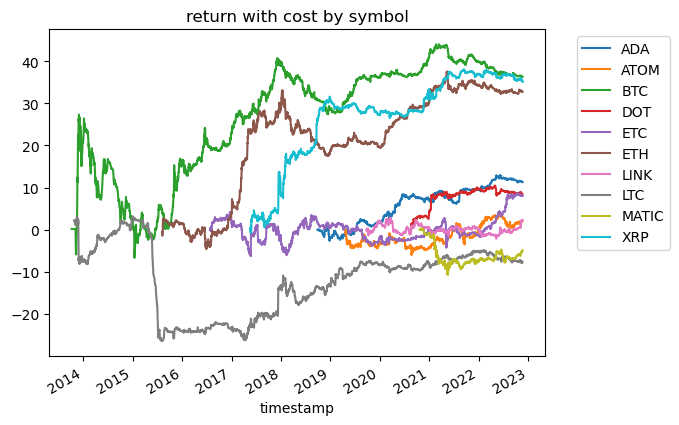

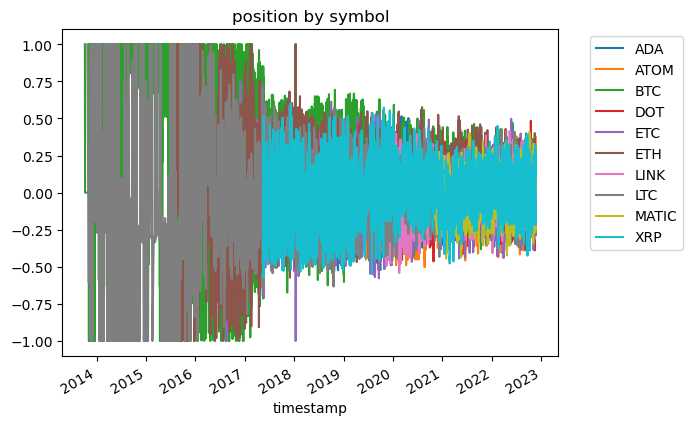

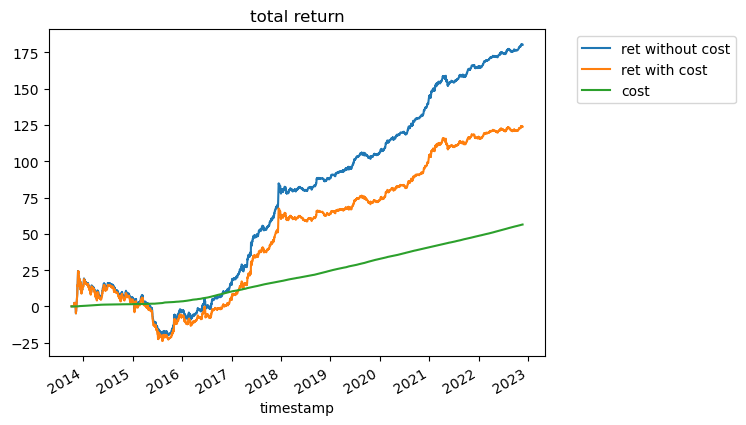

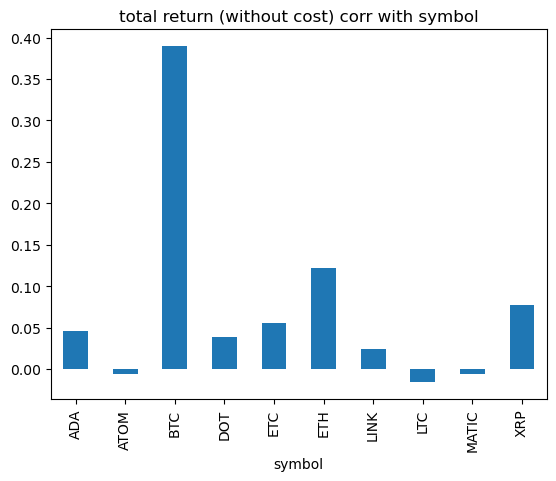

return without cost statistics
mean 0.002522532671516085
std 0.016198879390013243
sharpe 0.1557226651783857
double sharpe 0.9392929509204276
max drawdown 7.046651842297948
min -0.1470000163053937
min sharpe 0.017160084297375203
return with cost statistics
mean 0.001676106922186189
std 0.016195376402944793
sharpe 0.10349292788782753
double sharpe 0.5984075493895721
max drawdown 7.60243043450674
min -0.148329545171996
min sharpe 0.011299885806584614


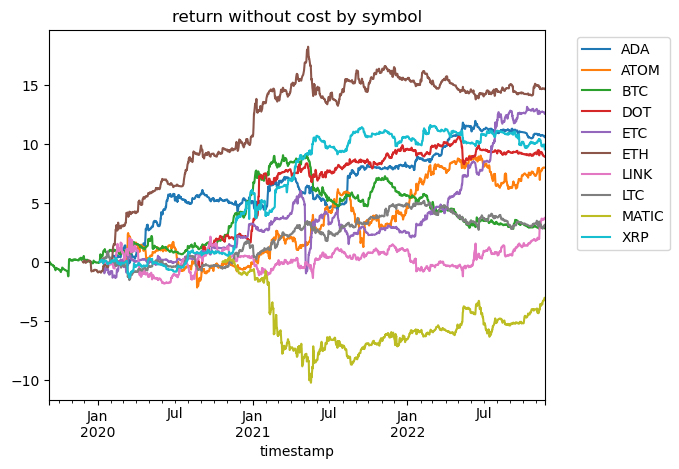

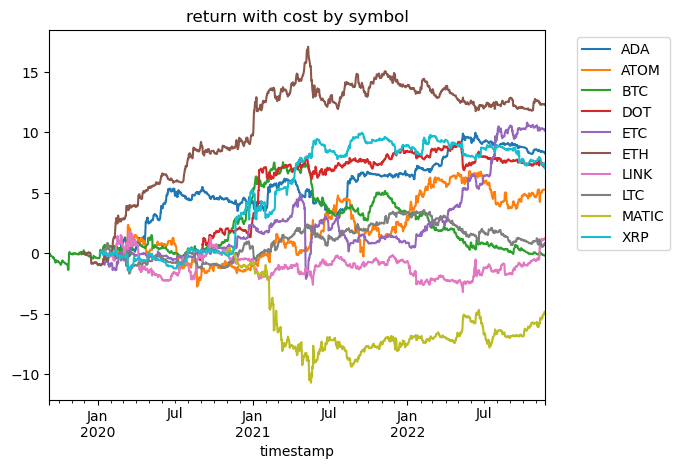

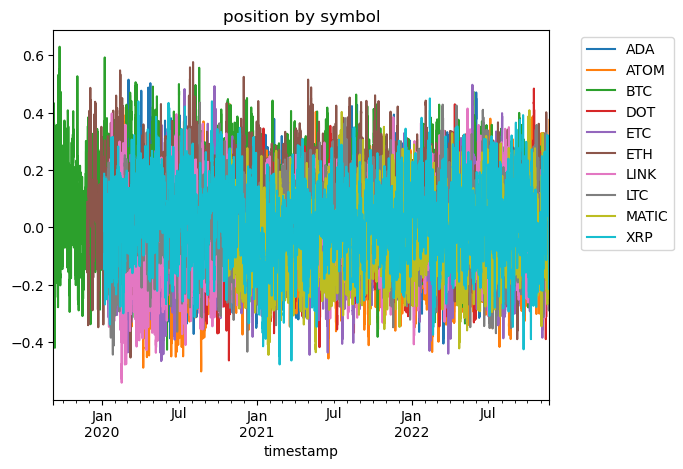

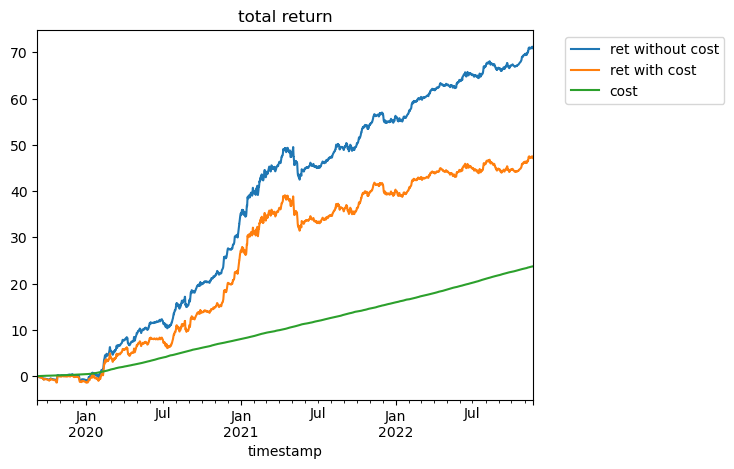

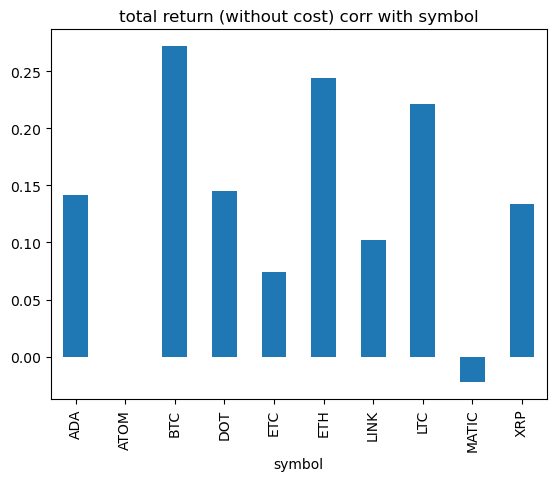

/tmp/ipykernel_12/2601597073.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta_weight'] = 1
/tmp/ipykernel_12/2601597073.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = beta_mean('ln_cl_diff')
/tmp/ipykernel_12/2601597073.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = f

fit df.shape (420925, 730)


In [5]:
df = pd.read_pickle('/tmp/df_binance_ohlcv_extended.pkl')
df = df.loc[df.index.get_level_values('timestamp') < pd.to_datetime('2022-11-22 00:00:00Z')]
# df = df.loc[df.index.get_level_values('timestamp') >= pd.to_datetime('2018-01-01 00:00:00Z')]

df['ret'] = df.groupby('symbol')['twap_5m'].transform(lambda x: x.shift(-25) / x.shift(-1) - 1).fillna(0)
df['execution_start_at'] = df.index.get_level_values('timestamp')

model = ExampleModelRank()

# cv
df_cv = calc_position_cv2(model, df)
visualize_result(df_cv.dropna())
visualize_result(df_cv.loc[~df['extended']].dropna())

# fit and save model as portable format
model.fit(df)
data = cloudpickle.dumps(model)
data = lzma.compress(data)
with open('/home/jovyan/data/{}.xz'.format(model_name), 'wb') as f:
    f.write(data)

/tmp/ipykernel_12/2601597073.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta_weight'] = 1
/tmp/ipykernel_12/2601597073.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = beta_mean('ln_cl_diff')
/tmp/ipykernel_12/2601597073.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = f

timestamp                  symbol
2022-09-23 05:00:00+00:00  ADA       0.098905
                           ATOM      0.131077
                           BTC       0.095579
                           DOT       0.096795
                           ETC       0.096718
                                       ...   
2022-11-22 04:00:00+00:00  LTC       0.081220
                           MATIC    -0.161534
                           XRP       0.143053
2022-11-22 05:00:00+00:00  ETC       0.483720
                           LTC      -0.516280
Name: position, Length: 14402, dtype: float64
['ADA', 'ATOM', 'BTC', 'DOT', 'ETC', 'ETH', 'LINK', 'LTC', 'MATIC', 'XRP']
test shift predict


/tmp/ipykernel_12/2601597073.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta_weight'] = 1
/tmp/ipykernel_12/2601597073.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = beta_mean('ln_cl_diff')
/tmp/ipykernel_12/2601597073.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = f

position1  position2  position3
timestamp                 symbol                                 
2022-09-23 06:00:00+00:00 ADA     -0.057115  -0.057115   0.097300
                          ATOM     0.056039   0.056039   0.098923
                          BTC      0.023743   0.023743   0.096897
                          DOT     -0.051091  -0.051091   0.094510
                          ETC     -0.019171  -0.019171   0.097099
...                                     ...        ...        ...
2022-11-22 04:00:00+00:00 ETH     -0.103358  -0.103358  -0.104347
                          LINK    -0.084967  -0.084967  -0.081726
                          LTC      0.081220   0.081220   0.081417
                          MATIC   -0.161534  -0.161534  -0.162896
                          XRP      0.143053   0.143053   0.143648

[14390 rows x 3 columns]

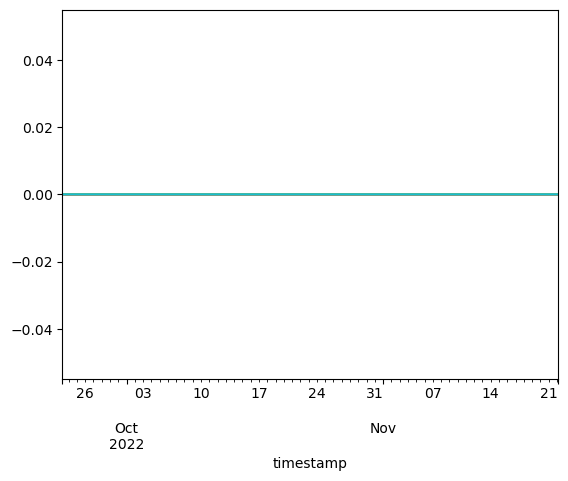

ADA (1439, 4)
ATOM (1439, 4)
BTC (1439, 4)
DOT (1439, 4)
ETC (1439, 4)
ETH (1439, 4)
LINK (1439, 4)
LTC (1439, 4)
MATIC (1439, 4)
XRP (1439, 4)


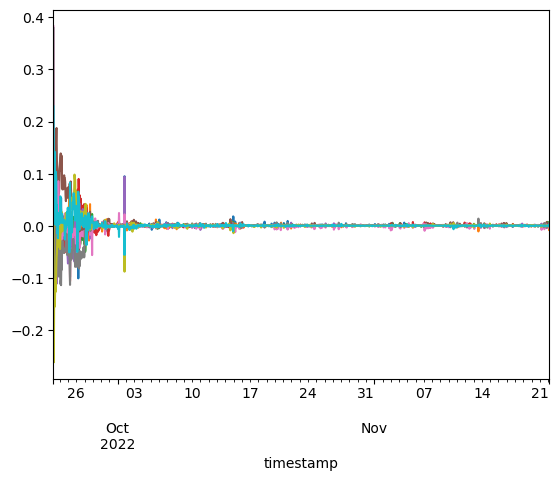

In [6]:
# model validation (Just run this cell in the new kernel to make sure you saved it in a portable format.)

import os
import joblib
import pandas as pd

model = joblib.load('/home/jovyan/data/{}.xz'.format(model_name))
df = pd.read_pickle('/tmp/df_binance_ohlcv_extended.pkl')
df = df[['op', 'hi', 'lo', 'cl', 'volume']]
max_timestamp = df.index.get_level_values('timestamp').max()
df = df.loc[max_timestamp - pd.to_timedelta(model.max_data_sec, unit='S') <= df.index.get_level_values('timestamp')]
print(model.predict(df))
print(model.symbols)



print('test shift predict')
import matplotlib.pyplot as plt

position1 = model.predict(df)
position2 = model.predict(df.loc[df.index.get_level_values('timestamp') < max_timestamp])
position3 = model.predict(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

test_timestamp = max_timestamp - pd.to_timedelta(1, unit='H')
df_test = pd.concat([
    position1.rename('position1'),
    position2.rename('position2'),
    position3.rename('position3'),
], axis=1)

df_test = df_test.dropna()
display(df_test)

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    (df_symbol['position2'] - df_symbol['position1']).plot()
plt.show()

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    print(symbol, df_symbol.shape)
    (df_symbol['position3'] - df_symbol['position1']).plot()
plt.show()